<a href="https://colab.research.google.com/github/ymartemyanov/price_metro_dependence/blob/main/Martemyanov_7112021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задание
Есть данные Авито по квартирам в Москве

Надо проанализировать то, что было на выходе:
1. Посмотреть зависимость цен и кол-ва квартир от станций метро, желательно с графиками, сделать выводы.
2. Изучить зависимость цен в зависимости от удаленности от станций метро. Сделать выводы, возможно посмотреть по конкретным станциям, если есть в этом необходимость
3. На основании данных о двухкомнатных квартирах, которые есть в парсинге подумать, каким образом можно оценить стоимость 1-к квартир для разных станций метро




### Загрузка библиотек, подключение G-drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from scipy import stats as st
import re
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Читаем данные в dataframe и обрабатываем, чистим

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2020_09_12_avito_moskva.csv', sep = ';')
del df['Unnamed: 0']
df

,0,1,2,3,4,5
0,13700000,"\n 2-к квартира, 65 м², 13/25 эт.\n",/moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...,"\n Лукинская ул., 10\n",Новопеределкино,"1,3 км"
1,7912000,"\n 2-к квартира, 43 м², 2/5 эт.\n",/moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...,"\n 12-я Парковая ул., 5\n",Первомайская,900 м
2,9390000,"\n 2-к квартира, 52.2 м², 4/17 эт.\n",/moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...,"\n Покровская ул., 17к2\n",Некрасовка,600 м
3,8667975,"\n 2-к квартира, 59.3 м², 13/25 эт.\n",/moskva/kvartiry/2-k_kvartira_59.3_m_1325_et._...,"\n Рождественская ул., 33\n",Некрасовка,200 м
4,9180000,"\n 2-к квартира, 58.9 м², 13/17 эт.\n",/moskva/kvartiry/2-k_kvartira_58.9_m_1317_et._...,"\n ул. Лавриненко, 1\n",Некрасовка,800 м
...,...,...,...,...,...,...
4288,9557050,"\n 2-к квартира, 65.4 м², 14/25 эт.\n",/moskva/kvartiry/2-k_kvartira_65.4_m_1425_et._...,"\n Рождественская ул., 33\n",Некрасовка,200 м
4289,8667975,"\n 2-к квартира, 59.3 м², 5/25 эт.\n",/moskva/kvartiry/2-k_kvartira_59.3_m_525_et._1...,"\n Рождественская ул., 33\n",Некрасовка,200 м
4290,8667975,"\n 2-к квартира, 59.3 м², 4/25 эт.\n",/moskva/kvartiry/2-k_kvartira_59.3_m_425_et._1...,"\n Рождественская ул., 33\n",Некрасовка,200 м
4291,3950000,"\n 2-к квартира, 58.5 м², 2/8 эт.\n",/moskva_zelenograd/kvartiry/2-k_kvartira_58.5_...,NaN,д. Елино,NaN


Удаляем строки с отсутствующим указанием метро (нет расстояния до метро)

In [ ]:
df.isna().sum()

0      0
1      0
2      0
3     82
4     13
5    148
dtype: int64

Видим, что в колонке '5' таких значений 148

In [ ]:
df1 = df.dropna().reset_index()
df1

,index,0,1,2,3,4,5
0,0,13700000,"\n 2-к квартира, 65 м², 13/25 эт.\n",/moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...,"\n Лукинская ул., 10\n",Новопеределкино,"1,3 км"
1,1,7912000,"\n 2-к квартира, 43 м², 2/5 эт.\n",/moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...,"\n 12-я Парковая ул., 5\n",Первомайская,900 м
2,2,9390000,"\n 2-к квартира, 52.2 м², 4/17 эт.\n",/moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...,"\n Покровская ул., 17к2\n",Некрасовка,600 м
3,3,8667975,"\n 2-к квартира, 59.3 м², 13/25 эт.\n",/moskva/kvartiry/2-k_kvartira_59.3_m_1325_et._...,"\n Рождественская ул., 33\n",Некрасовка,200 м
4,4,9180000,"\n 2-к квартира, 58.9 м², 13/17 эт.\n",/moskva/kvartiry/2-k_kvartira_58.9_m_1317_et._...,"\n ул. Лавриненко, 1\n",Некрасовка,800 м
...,...,...,...,...,...,...,...
4140,4287,8664000,"\n 2-к квартира, 65.2 м², 7/25 эт.\n",/moskva/kvartiry/2-k_kvartira_65.2_m_725_et._1...,"\n ул. Вертолётчиков, 1\n",Некрасовка,700 м
4141,4288,9557050,"\n 2-к квартира, 65.4 м², 14/25 эт.\n",/moskva/kvartiry/2-k_kvartira_65.4_m_1425_et._...,"\n Рождественская ул., 33\n",Некрасовка,200 м
4142,4289,8667975,"\n 2-к квартира, 59.3 м², 5/25 эт.\n",/moskva/kvartiry/2-k_kvartira_59.3_m_525_et._1...,"\n Рождественская ул., 33\n",Некрасовка,200 м
4143,4290,8667975,"\n 2-к квартира, 59.3 м², 4/25 эт.\n",/moskva/kvartiry/2-k_kvartira_59.3_m_425_et._1...,"\n Рождественская ул., 33\n",Некрасовка,200 м


Разделим колонку 1 на несколько столбцов

In [ ]:
df2 = df1['1'].str.replace("\n","")
df2= df2.str.split(" ", n = 6, expand = True).reset_index()
df2

,index,0,1,2,3,4,5,6
0,0,,2-к,"квартира,",65,"м²,",13/25,эт.
1,1,,2-к,"квартира,",43,"м²,",2/5,эт.
2,2,,2-к,"квартира,",52.2,"м²,",4/17,эт.
3,3,,2-к,"квартира,",59.3,"м²,",13/25,эт.
4,4,,2-к,"квартира,",58.9,"м²,",13/17,эт.
...,...,...,...,...,...,...,...,...
4140,4140,,2-к,"квартира,",65.2,"м²,",7/25,эт.
4141,4141,,2-к,"квартира,",65.4,"м²,",14/25,эт.
4142,4142,,2-к,"квартира,",59.3,"м²,",5/25,эт.
4143,4143,,2-к,"квартира,",59.3,"м²,",4/25,эт.


In [ ]:
df2 = df2[[3,5]]
df2[['apart_storeys', 'house_storeys']] = df2[5].str.split('/', 1, expand=True)
del df2[5]
df2.columns = ['area', 'apart_storeys', 'house_storeys']
df2

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,area,apart_storeys,house_storeys
0,65,13,25
1,43,2,5
2,52.2,4,17
3,59.3,13,25
4,58.9,13,17
...,...,...,...
4140,65.2,7,25
4141,65.4,14,25
4142,59.3,5,25
4143,59.3,4,25


Объединяем датафреймы и отбираем нужные поля

In [ ]:
df3 = df1[['0', '4', '5']].join(df2)
df3.columns = ['price', 'metro', 'distance', 'area', 'apart_storeys', 'house_storeys']
df3

,price,metro,distance,area,apart_storeys,house_storeys
0,13700000,Новопеределкино,"1,3 км",65,13,25
1,7912000,Первомайская,900 м,43,2,5
2,9390000,Некрасовка,600 м,52.2,4,17
3,8667975,Некрасовка,200 м,59.3,13,25
4,9180000,Некрасовка,800 м,58.9,13,17
...,...,...,...,...,...,...
4140,8664000,Некрасовка,700 м,65.2,7,25
4141,9557050,Некрасовка,200 м,65.4,14,25
4142,8667975,Некрасовка,200 м,59.3,5,25
4143,8667975,Некрасовка,200 м,59.3,4,25


Переведем расстояние до метро к метрам. Видим, что расстояние в метрах измеряется сотнями, а в километрах - десятичными числами меньшими 10.

In [ ]:
df3['distance'].unique()

array([' 1,3\xa0км', ' 900\xa0м', ' 600\xa0м', ' 200\xa0м', ' 800\xa0м',
       ' 2,3\xa0км', ' 500\xa0м', ' 1,8\xa0км', ' 400\xa0м', ' 700\xa0м',
       ' 1,6\xa0км', ' 1,5\xa0км', ' 300\xa0м', ' 2,5\xa0км',
       ' 2,2\xa0км', ' 1,1\xa0км', ' 1\xa0км', ' 1,4\xa0км', ' 2,6\xa0км',
       ' 3,8\xa0км', ' 1,2\xa0км', ' 2,7\xa0км', ' 1,9\xa0км', ' 2\xa0км',
       ' 1,7\xa0км', ' 100\xa0м', ' 3,6\xa0км', ' 3,7\xa0км',
       ' 2,4\xa0км', ' 2,1\xa0км', ' 2,8\xa0км', ' 3,2\xa0км',
       ' 4,1\xa0км', ' 3,9\xa0км', ' 3\xa0км', ' 3,1\xa0км', ' 4,3\xa0км',
       ' 2,9\xa0км', ' 4,5\xa0км', ' 3,3\xa0км', ' 4,8\xa0км',
       ' 3,5\xa0км', ' 4\xa0км', ' 4,2\xa0км', ' 4,7\xa0км', ' 3,4\xa0км',
       ' 4,6\xa0км'], dtype=object)

In [ ]:
df_dist = df3['distance'].str.replace(" ","")
df_dist = df_dist.str.replace("\xa0"," ")
df_dist

0       1,3 км
1        900 м
2        600 м
3        200 м
4        800 м
         ...  
4140     700 м
4141     200 м
4142     200 м
4143     200 м
4144     600 м
Name: distance, Length: 4145, dtype: object

In [ ]:
df_dist = df_dist.apply(lambda x: x.replace(',','.'))
df_dist = df_dist.str.split(' ', 1, expand=True).reset_index()
df_dist

,index,0,1
0,0,1.3,км
1,1,900,м
2,2,600,м
3,3,200,м
4,4,800,м
...,...,...,...
4140,4140,700,м
4141,4141,200,м
4142,4142,200,м
4143,4143,200,м


In [ ]:
df_cl = df3[['price', 'metro', 'area', 'apart_storeys', 'house_storeys']].join(df_dist[0])
df_cl.columns = ['price', 'metro', 'area', 'apart_storeys', 'house_storeys', 'distance']
df_cl

,price,metro,area,apart_storeys,house_storeys,distance
0,13700000,Новопеределкино,65,13,25,1.3
1,7912000,Первомайская,43,2,5,900
2,9390000,Некрасовка,52.2,4,17,600
3,8667975,Некрасовка,59.3,13,25,200
4,9180000,Некрасовка,58.9,13,17,800
...,...,...,...,...,...,...
4140,8664000,Некрасовка,65.2,7,25,700
4141,9557050,Некрасовка,65.4,14,25,200
4142,8667975,Некрасовка,59.3,5,25,200
4143,8667975,Некрасовка,59.3,4,25,200


In [ ]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          4145 non-null   int64 
 1   metro          4145 non-null   object
 2   area           4145 non-null   object
 3   apart_storeys  4145 non-null   object
 4   house_storeys  4145 non-null   object
 5   distance       4145 non-null   object
dtypes: int64(1), object(5)
memory usage: 194.4+ KB


Меняем тип колонок на числовые

In [ ]:
df_cl['area'] = df_cl['area'].astype(float)
df_cl['apart_storeys'] = df_cl['apart_storeys'].astype(int)
df_cl['house_storeys'] = df_cl['house_storeys'].astype(int)
df_cl['distance'] = df_cl['distance'].astype(float)
df_cl

,price,metro,area,apart_storeys,house_storeys,distance
0,13700000,Новопеределкино,65.0,13,25,1.3
1,7912000,Первомайская,43.0,2,5,900.0
2,9390000,Некрасовка,52.2,4,17,600.0
3,8667975,Некрасовка,59.3,13,25,200.0
4,9180000,Некрасовка,58.9,13,17,800.0
...,...,...,...,...,...,...
4140,8664000,Некрасовка,65.2,7,25,700.0
4141,9557050,Некрасовка,65.4,14,25,200.0
4142,8667975,Некрасовка,59.3,5,25,200.0
4143,8667975,Некрасовка,59.3,4,25,200.0


In [ ]:
df_cl['distance'] = df_cl['distance'].apply(lambda d: d if d>50 else d*1000)
df_cl

,price,metro,area,apart_storeys,house_storeys,distance
0,13700000,Новопеределкино,65.0,13,25,1300.0
1,7912000,Первомайская,43.0,2,5,900.0
2,9390000,Некрасовка,52.2,4,17,600.0
3,8667975,Некрасовка,59.3,13,25,200.0
4,9180000,Некрасовка,58.9,13,17,800.0
...,...,...,...,...,...,...
4140,8664000,Некрасовка,65.2,7,25,700.0
4141,9557050,Некрасовка,65.4,14,25,200.0
4142,8667975,Некрасовка,59.3,5,25,200.0
4143,8667975,Некрасовка,59.3,4,25,200.0


In [ ]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4145 non-null   int64  
 1   metro          4145 non-null   object 
 2   area           4145 non-null   float64
 3   apart_storeys  4145 non-null   int64  
 4   house_storeys  4145 non-null   int64  
 5   distance       4145 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 194.4+ KB


Избавимся от дубликатов

In [ ]:
df_cl = df_cl.drop_duplicates()
df_cl

,price,metro,area,apart_storeys,house_storeys,distance
0,13700000,Новопеределкино,65.0,13,25,1300.0
1,7912000,Первомайская,43.0,2,5,900.0
2,9390000,Некрасовка,52.2,4,17,600.0
3,8667975,Некрасовка,59.3,13,25,200.0
4,9180000,Некрасовка,58.9,13,17,800.0
...,...,...,...,...,...,...
4139,8664000,Некрасовка,65.2,20,25,700.0
4140,8664000,Некрасовка,65.2,7,25,700.0
4142,8667975,Некрасовка,59.3,5,25,200.0
4143,8667975,Некрасовка,59.3,4,25,200.0


Добавим цену за кв. м. как универсальный показатель. Нулевые значения площади отсутствуют, показатель варьируется от 25 кв м до 532 кв м

In [ ]:
df_cl['area'].sort_values().unique()

array([ 25. ,  25.2,  26. ,  26.7,  27. ,  32. ,  32.8,  33. ,  33.1,
        33.8,  33.9,  34. ,  34.2,  34.3,  34.4,  34.5,  35. ,  35.3,
        35.4,  35.5,  35.9,  36. ,  36.6,  36.7,  36.8,  36.9,  37. ,
        37.1,  37.2,  37.3,  37.4,  37.5,  37.6,  37.7,  37.8,  37.9,
        38. ,  38.1,  38.2,  38.3,  38.4,  38.5,  38.6,  38.7,  38.8,
        38.9,  39. ,  39.1,  39.2,  39.3,  39.4,  39.5,  39.6,  39.7,
        39.8,  39.9,  40. ,  40.1,  40.3,  40.4,  40.5,  40.6,  40.7,
        40.8,  40.9,  41. ,  41.1,  41.2,  41.3,  41.4,  41.5,  41.6,
        41.7,  41.8,  41.9,  42. ,  42.1,  42.2,  42.3,  42.4,  42.5,
        42.6,  42.7,  42.8,  42.9,  43. ,  43.1,  43.2,  43.3,  43.4,
        43.5,  43.6,  43.7,  43.8,  43.9,  44. ,  44.1,  44.2,  44.3,
        44.4,  44.5,  44.6,  44.7,  44.8,  44.9,  45. ,  45.1,  45.2,
        45.3,  45.4,  45.5,  45.6,  45.7,  45.8,  45.9,  46. ,  46.1,
        46.2,  46.3,  46.4,  46.5,  46.6,  46.7,  46.8,  46.9,  47. ,
        47.1,  47.2,

In [ ]:
df_cl['price_per_sqm'] = round(df_cl['price'] / df_cl['area'],2)
df_cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,price,metro,area,apart_storeys,house_storeys,distance,price_per_sqm
0,13700000,Новопеределкино,65.0,13,25,1300.0,210769.23
1,7912000,Первомайская,43.0,2,5,900.0,184000.00
2,9390000,Некрасовка,52.2,4,17,600.0,179885.06
3,8667975,Некрасовка,59.3,13,25,200.0,146171.59
4,9180000,Некрасовка,58.9,13,17,800.0,155857.39
...,...,...,...,...,...,...,...
4139,8664000,Некрасовка,65.2,20,25,700.0,132883.44
4140,8664000,Некрасовка,65.2,7,25,700.0,132883.44
4142,8667975,Некрасовка,59.3,5,25,200.0,146171.59
4143,8667975,Некрасовка,59.3,4,25,200.0,146171.59


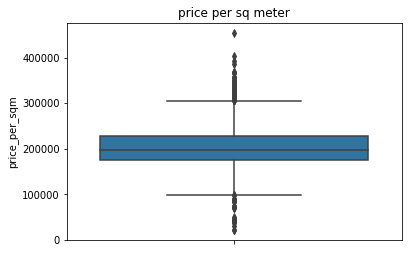

count      3975.000000
mean     202507.996808
std       44075.117174
min       20676.690000
25%      176008.940000
50%      197872.340000
75%      227918.175000
max      454545.450000
Name: price_per_sqm, dtype: float64


In [ ]:
plt.title('price per sq meter')
sns.boxplot(y=df_cl.price_per_sqm)
plt.show()
print(df_cl.price_per_sqm.describe())

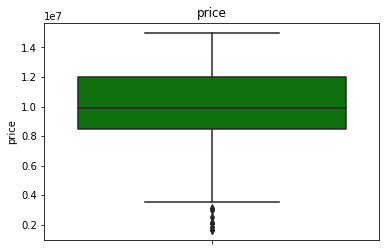

count      3975.000000
mean     202507.996808
std       44075.117174
min       20676.690000
25%      176008.940000
50%      197872.340000
75%      227918.175000
max      454545.450000
Name: price_per_sqm, dtype: float64


In [ ]:
plt.title('price')
sns.boxplot(y=df_cl.price, color = 'g')
plt.show()
print(df_cl.price_per_sqm.describe())

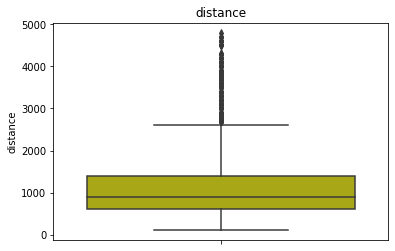

count      3975.000000
mean     202507.996808
std       44075.117174
min       20676.690000
25%      176008.940000
50%      197872.340000
75%      227918.175000
max      454545.450000
Name: price_per_sqm, dtype: float64


In [ ]:
plt.title('distance')
sns.boxplot(y=df_cl.distance, color = 'y')
plt.show()
print(df_cl.price_per_sqm.describe())

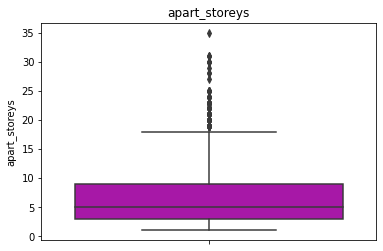

count      3975.000000
mean     202507.996808
std       44075.117174
min       20676.690000
25%      176008.940000
50%      197872.340000
75%      227918.175000
max      454545.450000
Name: price_per_sqm, dtype: float64


In [ ]:
plt.title('apart_storeys')
sns.boxplot(y=df_cl.apart_storeys, color = 'm')
plt.show()
print(df_cl.price_per_sqm.describe())

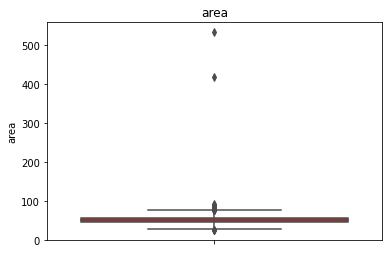

count      3975.000000
mean     202507.996808
std       44075.117174
min       20676.690000
25%      176008.940000
50%      197872.340000
75%      227918.175000
max      454545.450000
Name: price_per_sqm, dtype: float64


In [ ]:
plt.title('area')
sns.boxplot(y=df_cl.area, color = 'r')
plt.show()
print(df_cl.price_per_sqm.describe())

Можно видеть два выброса: свыше 400м2 и свыше 500м2, их можно удалить для однородности выборки.

Выбросы особенно заметны, если построить диаграмму рассеяния площади и цены за м2

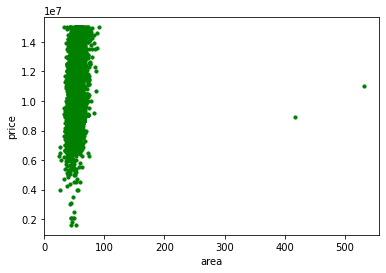

In [ ]:
df_cl.plot.scatter(x = 'area', y = 'price', s = 10, color = 'g')

In [ ]:
df_cl = df_cl[df_cl['area']<400]
df_cl

,price,metro,area,apart_storeys,house_storeys,distance,price_per_sqm
0,13700000,Новопеределкино,65.0,13,25,1300.0,210769.23
1,7912000,Первомайская,43.0,2,5,900.0,184000.00
2,9390000,Некрасовка,52.2,4,17,600.0,179885.06
3,8667975,Некрасовка,59.3,13,25,200.0,146171.59
4,9180000,Некрасовка,58.9,13,17,800.0,155857.39
...,...,...,...,...,...,...,...
4139,8664000,Некрасовка,65.2,20,25,700.0,132883.44
4140,8664000,Некрасовка,65.2,7,25,700.0,132883.44
4142,8667975,Некрасовка,59.3,5,25,200.0,146171.59
4143,8667975,Некрасовка,59.3,4,25,200.0,146171.59


После удаления выбросов данные рассеяны более равномерно. Можно видеть, например, что нет явной зависимости абсолютной стоимости от площади

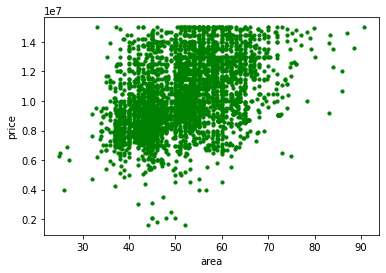

In [ ]:
df_cl.plot.scatter(x = 'area', y = 'price', s = 10, color = 'g')

При оценивании зависимости цены за квадратный метр от площади видна более четкая отрицательная зависимость

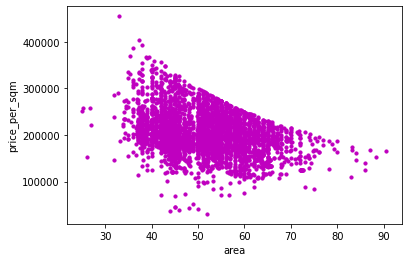

In [ ]:
df_cl.plot.scatter(x = 'area', y = 'price_per_sqm', s = 10, color = 'm')

##1. Зависимость цен и количества квартир от станций метро

Оценим распределения основных числовых показателей

In [ ]:
df_cl.describe()

,price,area,apart_storeys,house_storeys,distance,price_per_sqm
count,3.973000e+03,3973.000000,3973.000000,3973.000000,3973.000000,3973.000000
mean,1.023684e+07,51.121369,6.584948,12.936320,1085.023911,202599.362620
std,2.301122e+06,8.616222,5.115055,6.553615,792.309289,43897.594456
min,1.600000e+06,25.000000,1.000000,1.000000,100.000000,30769.230000
25%,8.500000e+06,44.500000,3.000000,9.000000,600.000000,176136.360000
50%,9.900000e+06,51.000000,5.000000,12.000000,900.000000,197884.620000
75%,1.200000e+07,56.800000,9.000000,17.000000,1400.000000,227929.370000
max,1.500000e+07,90.600000,35.000000,58.000000,4800.000000,454545.450000


Цена за кв м выглядит нормально распределенной величиной со средним значением чуть выше 200тыс р за кв м

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


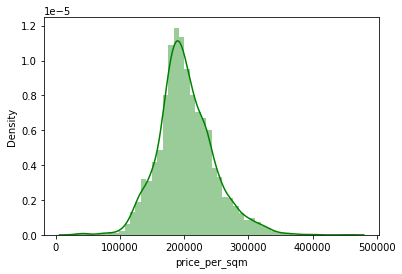

In [ ]:
sns.distplot(df_cl.price_per_sqm, color = 'g')
plt.show()

Абсолютные значения цены варьируются значительно

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


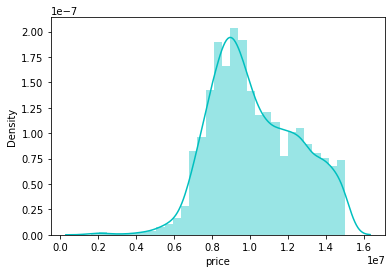

In [ ]:
sns.distplot(df_cl.price, color = 'c')
plt.show()

Распределение площади имеет два выраженных пика около квартир 43м2 и 51-53м2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


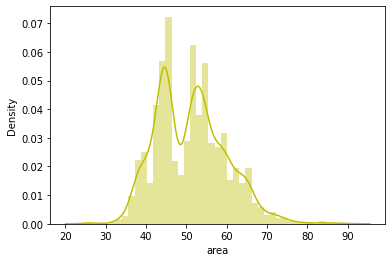

In [ ]:
sns.distplot(df_cl.area, color = 'y')
plt.show()

Распределение этажей имеет толстый правый хвост, чем выше этажность квартиры, тем реже она встречается, большинство представлены низкой этажностью (до 5 этажей)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


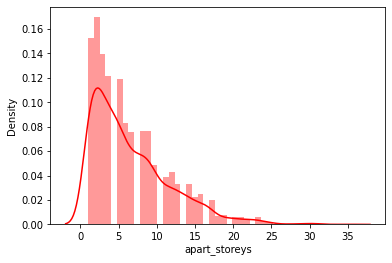

In [ ]:
sns.distplot(df_cl.apart_storeys, color = 'r')
plt.show()

Распределение расстояния до метро тоже имеет толстый правый хвост, в основном квартиры расположены до 1 км от метро

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


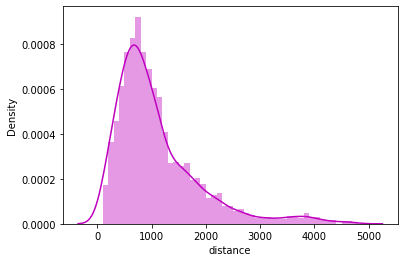

In [ ]:
sns.distplot(df_cl.distance, color = 'm')
plt.show()

Оценим корреляции между различными характеристиками, построим полную корреляционную матрицу:

In [ ]:
df_cl.corr()

,price,area,apart_storeys,house_storeys,distance,price_per_sqm
price,1.000000,0.425619,0.143810,0.229265,-0.250554,0.707696
area,0.425619,1.000000,0.291268,0.441191,0.068734,-0.318192
apart_storeys,0.143810,0.291268,1.000000,0.562547,0.069328,-0.055247
house_storeys,0.229265,0.441191,0.562547,1.000000,0.074378,-0.077129
distance,-0.250554,0.068734,0.069328,0.074378,1.000000,-0.307796
price_per_sqm,0.707696,-0.318192,-0.055247,-0.077129,-0.307796,1.000000


Зависимость между ценой за кв м и площадью является умеренной и отрицательной

Оценим предложения двухкомнатных квартир

In [ ]:
dfg = df_cl.metro.value_counts().reset_index(name='count')
dfg.columns = ['metro', 'count']
dfg

,metro,count
0,Некрасовка,214
1,Молодежная,100
2,Улица Скобелевская,98
3,Селигерская,96
4,Новогиреево,78
...,...,...
200,Добрынинская,1
201,Филатов луг,1
202,Пионерская,1
203,Киевская,1


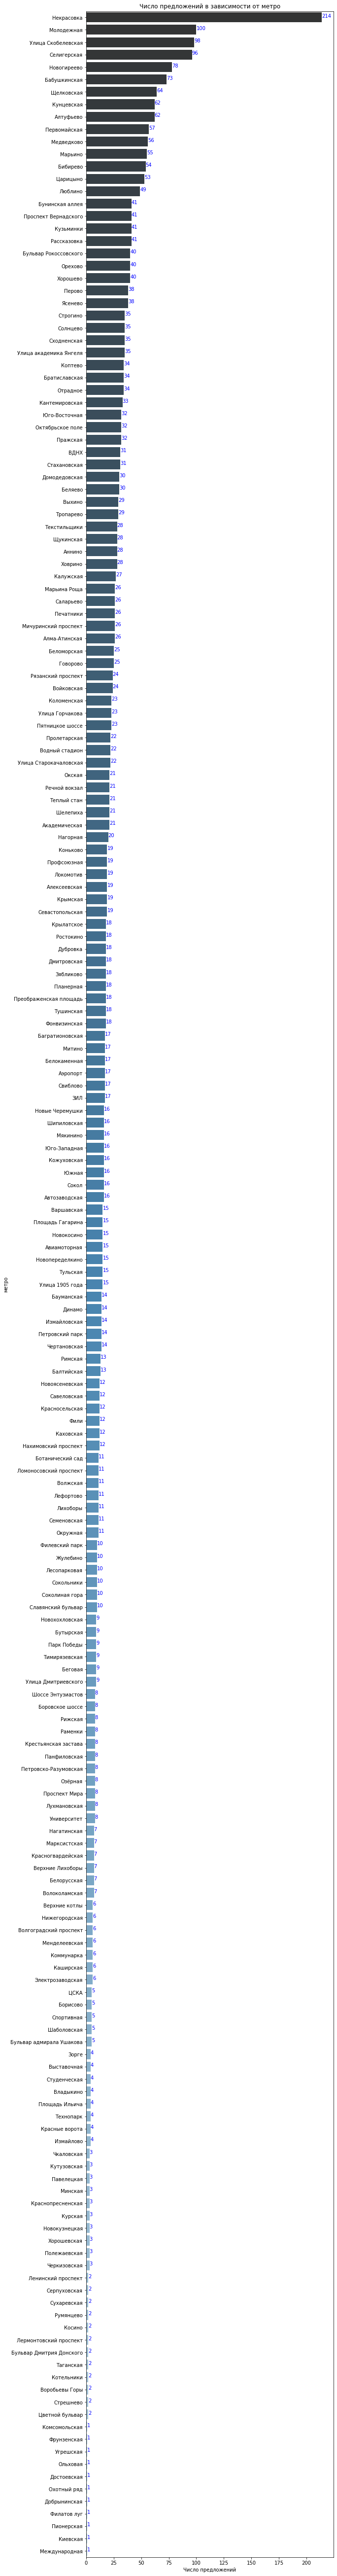

In [ ]:
plt.figure(figsize=(9,95))
plt.title("Число предложений в зависимости от метро")

pal = sns.color_palette("Blues_d", len(dfg))
rank = dfg.index

sns.barplot(x=dfg['count'], y=dfg['metro'], palette=np.array(pal[::-1])[rank])
plt.ylabel("метро")
plt.xlabel("Число предложений")

for j in range(len(dfg)):
    plt.text(dfg.values[j][1], j, int(dfg.values[j][1]), color = 'b')

In [ ]:
metro_df_cl = df_cl.pivot_table(index='metro', values='price_per_sqm', aggfunc='mean').sort_values(by='price_per_sqm', ascending=False).reset_index()
metro_df_cl

,metro,price_per_sqm
0,Фрунзенская,392105.260000
1,Киевская,348837.210000
2,Краснопресненская,343630.953333
3,Сухаревская,332199.755000
4,Новокузнецкая,321111.110000
...,...,...
200,Аннино,160730.594286
201,Улица Горчакова,158496.254783
202,Некрасовка,142428.620140
203,Улица Скобелевская,141581.380306


Text(0.5, 0, 'цена за метр')

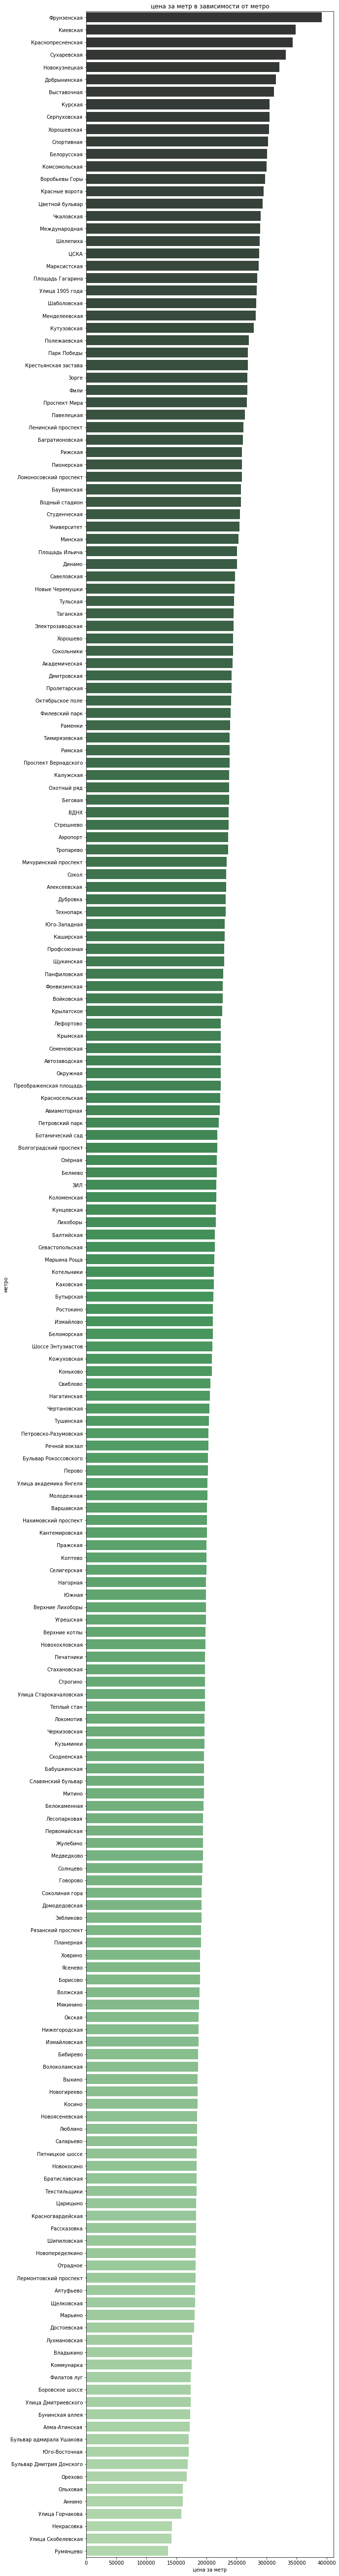

In [ ]:
plt.figure(figsize=(9,95))
plt.title("цена за метр в зависимости от метро")

pal = sns.color_palette("Greens_d", len(metro_df_cl))
rank = metro_df_cl.index

sns.barplot(x=metro_df_cl['price_per_sqm'], y=metro_df_cl['metro'], palette=np.array(pal[::-1])[rank])
plt.ylabel("метро")
plt.xlabel("цена за метр")

Оценим зависимость количества предложений от цены за кв метр

In [ ]:
dfg1 = dfg.merge(metro_df_cl, how = 'left', on = 'metro')
dfg1

,metro,count,price_per_sqm
0,Некрасовка,214,142428.620140
1,Молодежная,100,201929.738600
2,Улица Скобелевская,98,141581.380306
3,Селигерская,96,199699.771146
4,Новогиреево,78,185675.705769
...,...,...,...
200,Добрынинская,1,315789.470000
201,Охотный ряд,1,237704.920000
202,Пионерская,1,258928.570000
203,Комсомольская,1,300000.000000


Можно видеть, что станции метро с наиболее дорогими квартирами предлагаются как правило редко. Частые предложения свойственны станциям с относительно небольшой стоимостью за кв м

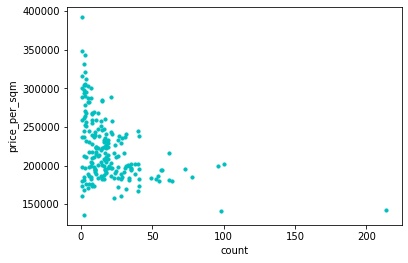

In [ ]:
dfg1.plot.scatter(x = 'count', y = 'price_per_sqm', s = 10, color = 'c')

##Зависимость цен от удаленности от станций метро

Корреляция между абсолютной ценой и абсолютным расстоянием ни о чем не говорит кроме того, что наибольшая плотность квартир с наименьшим расстоянием расположена в левом верхнем углу, то есть самые дорогие квартиры сконцентрированы там

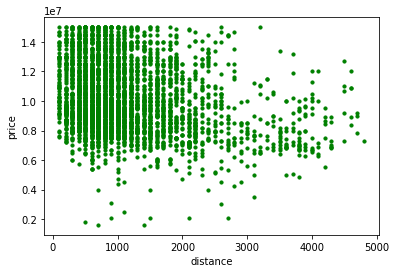

In [ ]:
df_cl.plot.scatter(x = 'distance', y = 'price', s = 10, color = 'g')

Корреляция между ценой за квадратный метр и расстоянием прослеживается четче

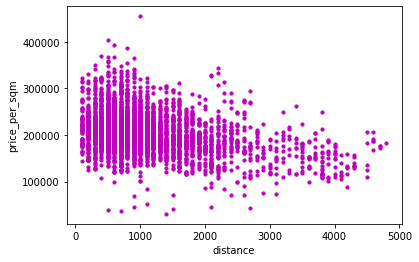

In [ ]:
df_cl.plot.scatter(x = 'distance', y = 'price_per_sqm', s = 10, color = 'm')

In [ ]:
dist_df = df_cl.pivot_table(index='price_per_sqm', values='distance', aggfunc='mean').sort_values(by='distance', ascending=True).reset_index()
dist_df

,price_per_sqm,distance
0,270380.43,100.0
1,211180.12,100.0
2,272222.22,100.0
3,211246.20,100.0
4,220382.51,100.0
...,...,...
2843,135185.19,4500.0
2844,110843.37,4500.0
2845,124563.45,4500.0
2846,186643.84,4600.0


В целом стоимость квадратного метра снижается с увеличением расстояния от метро

Text(0.5, 0, 'Удаленность от метро (м)')

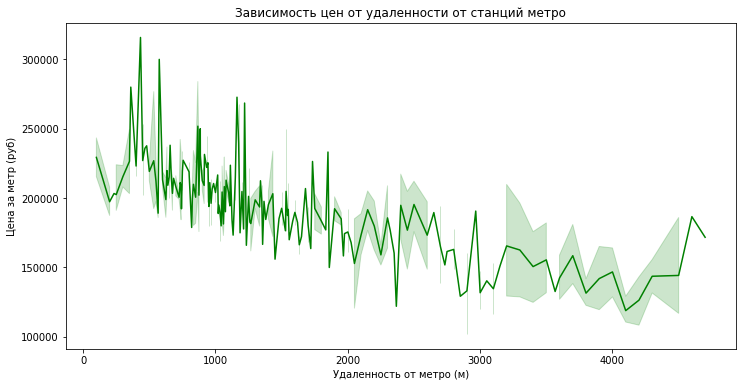

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Зависимость цен от удаленности от станций метро")
sns.lineplot(data = dist_df, x='distance', y='price_per_sqm', color = 'g')
plt.ylabel("Цена за метр (руб)")
plt.xlabel("Удаленность от метро (м)")

Коэффициент корреляции Пирсона составляет -0.3 (характеризует существование линейной связи), то есть связь умеренная отрицательная

In [ ]:
st.pearsonr(df_cl['distance'].values,df_cl['price_per_sqm'].values)[0]

-0.3077960080403859

Сгруппируем удаленность от метро по километрам

In [ ]:
df_cl['distance_km_grouped'] = '0-1km'
df_cl.loc[df_cl['distance']>=3000, 'distance_km_grouped'] = '3km+'
df_cl.loc[(df_cl['distance']>=1000)&(df_cl['distance']<2000), 'distance_km_grouped'] = '1-2km'
df_cl.loc[(df_cl['distance']>=2000)&(df_cl['distance']<3000), 'distance_km_grouped'] = '2-3km'
df_cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,price,metro,area,apart_storeys,house_storeys,distance,price_per_sqm,distance_km_grouped
0,13700000,Новопеределкино,65.0,13,25,1300.0,210769.23,1-2km
1,7912000,Первомайская,43.0,2,5,900.0,184000.00,0-1km
2,9390000,Некрасовка,52.2,4,17,600.0,179885.06,0-1km
3,8667975,Некрасовка,59.3,13,25,200.0,146171.59,0-1km
4,9180000,Некрасовка,58.9,13,17,800.0,155857.39,0-1km
...,...,...,...,...,...,...,...,...
4139,8664000,Некрасовка,65.2,20,25,700.0,132883.44,0-1km
4140,8664000,Некрасовка,65.2,7,25,700.0,132883.44,0-1km
4142,8667975,Некрасовка,59.3,5,25,200.0,146171.59,0-1km
4143,8667975,Некрасовка,59.3,4,25,200.0,146171.59,0-1km


In [ ]:
dist_df = df_cl.pivot_table(index='distance_km_grouped', values='price_per_sqm', aggfunc='mean').reset_index()
dist_df

,distance_km_grouped,price_per_sqm
0,0-1km,211116.409131
1,1-2km,199438.197872
2,2-3km,179470.511331
3,3km+,154544.084783


Text(0.5, 0, 'Средняя цена за метр')

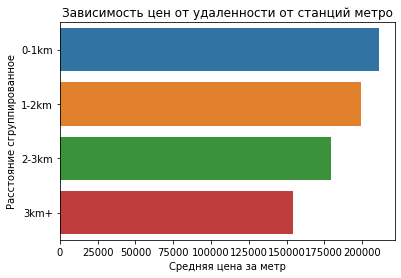

In [ ]:
plt.figure()
plt.title("Зависимость цен от удаленности от станций метро")
sns.barplot(y=dist_df['distance_km_grouped'], x=dist_df['price_per_sqm'], orient= 'h')
plt.ylabel("Расстояние сгруппированное")
plt.xlabel("Средняя цена за метр")

На сгруппированных по километражу данных видна четкая отрицательная зависимость цены за квадратный метр от расстояния до метро

##На основании данных о 2 к.кв. оценить стоимость 1 к.кв. для разных станций метро

Ранее уже оценили зависимость стоимости за квадратный метр от площади квартиры

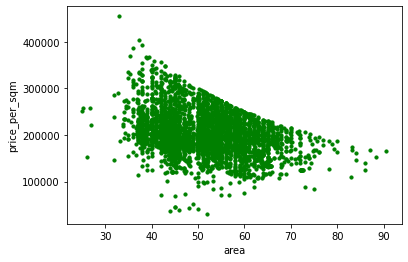

In [ ]:
df_cl.plot.scatter(x = 'area', y = 'price_per_sqm', s = 10, color = 'g')

Данная зависимость отрицательная и умеренная либо слабая, то есть однокомнатные квартиры будут стоит чуть дороже в пересчете за метр квадратный. Для более точной информации можно также воспользоваться внешними данными

Если сравнить среднюю стоимость цены за квадратный метр для 1 к кв и 2 к кв, то на основании внешних источников можно оценить их следующим образом: https://msk.etagi.com/analytics/?city_id=155&class=flats&type[]=2&type[]=3&date_from=2020-11-07&date_to=2021-11-07&resolution=70&country_id=1


> 1 к кв: 287143 руб/кв м

> 2 к кв: 279056 руб/кв м


Соотношение цен "однушек" к "двушкам":

In [ ]:
287143/279056

1.028979846339086

Используя данный коэффициент, можно получить стоимость за квадратный метр для станций метро

In [ ]:
metro_df_cl['price_per_sqm_for_1'] = metro_df_cl['price_per_sqm'] * 1.028979846339086
metro_df_cl

,metro,price_per_sqm,price_per_sqm_for_1
0,Фрунзенская,392105.260000,403468.410184
1,Киевская,348837.210000,358946.458743
2,Краснопресненская,343630.953333,353589.325558
3,Сухаревская,332199.755000,341826.852854
4,Новокузнецкая,321111.110000,330416.860626
...,...,...,...
200,Аннино,160730.594286,165388.542210
201,Улица Горчакова,158496.254783,163089.451892
202,Некрасовка,142428.620140,146556.179666
203,Улица Скобелевская,141581.380306,145684.386952


Text(0.5, 0, 'цена за метр')

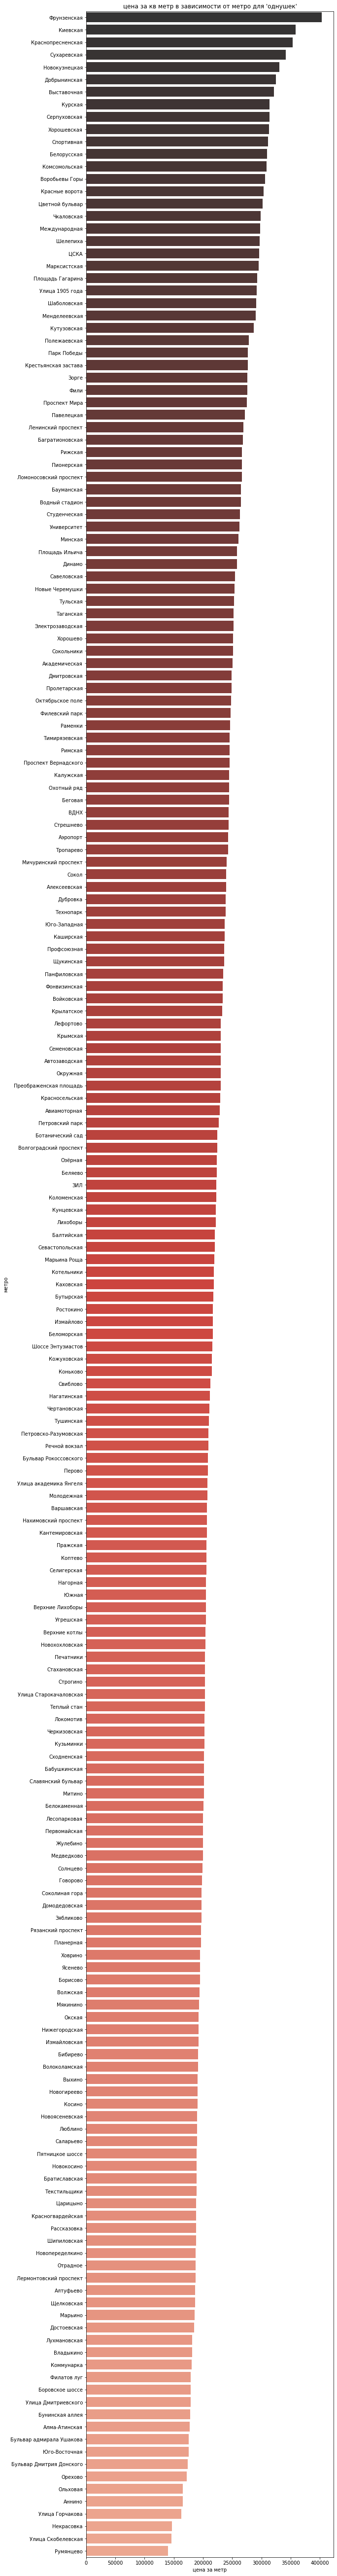

In [ ]:
plt.figure(figsize=(9,95))
plt.title("цена за кв метр в зависимости от метро для 'однушек'")

pal = sns.color_palette("Reds_d", len(metro_df_cl))
rank = metro_df_cl.index

sns.barplot(x=metro_df_cl['price_per_sqm_for_1'], y=metro_df_cl['metro'], palette=np.array(pal[::-1])[rank])
plt.ylabel("метро")
plt.xlabel("цена за метр")

Для расчета абсолютной стоимости однокомнатной квартиры нужно умножить среднюю стоимость цены за квадратный метр на площадь

Еще можно проанализировать стоимость только квартир с площадью, например, до 55 квадратных метров, своего рода аналоги "однушек"

In [ ]:
df_55 = df_cl[df_cl['area']<=55]
df_55

,price,metro,area,apart_storeys,house_storeys,distance,price_per_sqm,distance_km_grouped
1,7912000,Первомайская,43.0,2,5,900.0,184000.00,0-1km
2,9390000,Некрасовка,52.2,4,17,600.0,179885.06,0-1km
6,8300000,Улица академика Янгеля,44.5,2,9,800.0,186516.85,0-1km
7,7599000,Окская,42.0,5,5,500.0,180928.57,0-1km
8,12000000,Свиблово,53.0,12,12,1800.0,226415.09,1-2km
...,...,...,...,...,...,...,...,...
4125,11150000,Улица 1905 года,44.0,1,3,900.0,253409.09,0-1km
4130,9200000,Нахимовский проспект,44.3,1,5,1400.0,207674.94,1-2km
4132,10741606,Новогиреево,53.5,5,11,1900.0,200777.68,1-2km
4134,8899000,Кузьминки,34.4,6,9,1000.0,258691.86,1-2km


In [ ]:
metro_55 = df_55.pivot_table(index='metro', values='price_per_sqm', aggfunc='mean').sort_values(by='price_per_sqm', ascending=False).reset_index()
metro_55.columns = ['metro', 'price_per_sqm_55']
metro_55

,metro,price_per_sqm_55
0,Фрунзенская,392105.260000
1,Зорге,358024.690000
2,Киевская,348837.210000
3,Краснопресненская,343630.953333
4,Сухаревская,332199.755000
...,...,...
194,Улица Горчакова,163942.070000
195,Лермонтовский проспект,163533.830000
196,Улица Скобелевская,154522.965185
197,Аннино,152423.647826


Можно сравнить результаты с полученными ранее

In [ ]:
df1_2 = metro_55.merge(metro_df_cl, how = 'left', on = 'metro')
df1_2

,metro,price_per_sqm_55,price_per_sqm,price_per_sqm_for_1
0,Фрунзенская,392105.260000,392105.260000,403468.410184
1,Зорге,358024.690000,268390.027500,276167.929256
2,Киевская,348837.210000,348837.210000,358946.458743
3,Краснопресненская,343630.953333,343630.953333,353589.325558
4,Сухаревская,332199.755000,332199.755000,341826.852854
...,...,...,...,...
194,Улица Горчакова,163942.070000,158496.254783,163089.451892
195,Лермонтовский проспект,163533.830000,181766.915000,187034.492266
196,Улица Скобелевская,154522.965185,141581.380306,145684.386952
197,Аннино,152423.647826,160730.594286,165388.542210


В целом результаты отличаются не сильно при разных подходах, но видно, например, что станция Зорге выбилась в лидеры по стоимости квадратного метра при квартирах с относительно небольшой площадью

Для некоторых станций стоимость за квадратный метр даже снизилась, поэтому такой подход менее предпочтителен.

##Выводы

##1
> Наиболее дорогая недвижимость в расчете за квадратный метр встречается у станций метро Фрунзенская (392105 руб/м2), Киевская (348837 руб/м2),  Краснопресненская (343631 руб/м2), Сухаревская (332200 руб/м2), Новокузнецкая (321111 руб/м2).



> Недвижимость с самой низкой стоимостью квадратного метра находится у станций Румянцево - станция Новой Москвы, Улица Скобелевская, Улица Горчакова - Бутовская линия, Некрасовка - за пределами МКАД, Аннино - самая южная станция метро в пределах МКАД. Стоимость колеблется от 136 до 161 тыс руб. за кв. м.


> Наибольшее количество предложений свойственно станциям с относительно небольшой стоимостью за кв м, поэтому больше всего предложений встречается в Некрасовке (214), Молодежной (100), Улице Скобелевской (98), Селигерской (96), Новогиреево (78).



> Всего 1 предложение встречается у станций Охотный ряд	(237705 р/м2), Добрынинская (315789 р/м2), Достоевская	(179837 р/м2), Филатов луг	(173913 р/м2), Фрунзенская	(392105 р/м2), Угрешская	(198895 р/м2), Международная	(289575 р/м2), Киевская (348837 р/м2), Комсомольская	(300000 р/м2), Пионерская (258929 р/м2), Ольховая (161111 р/м2). Фрунзенская и Киевская - станции с самой дорогой недвижимостью.


##2
Цена квадратного метра снижается с увеличением расстояния от метро, коэффициент корреляции Пирсона показывает умеренную отрицательную линейную зависимость.

Удобно смотреть на агрегированные данные. Если сгруппировать расстояние по километражу, на данных видна четкая отрицательная зависимость цены за квадратный метр от расстояния до метро

##3

Если сравнить среднюю стоимость цены за квадратный метр для 1 к кв и 2 к кв, то на основании внешних источников можно оценить их следующим образом: https://msk.etagi.com/analytics/?city_id=155&class=flats&type[]=2&type[]=3&date_from=2020-11-07&date_to=2021-11-07&resolution=70&country_id=1

Соотношение цен "однушек" к "двушкам" составляет 1.028979846339086. Используя данный коэффициент, можно получить стоимость за квадратный метр для станций метро, а также рассчитать абсолютную стоимость однокомнатной квартиры, умножив среднюю стоимость цены за квадратный метр на площадь.

Еще можно проанализировать стоимость только квартир с относительно меньшей площадью, например, до 55 квадратных метров, некоторого рода аналогов однокомнатных квартир. Результаты будут не сильно отличаться, правда, в этом случае в лидеры по стоимости за квадратный метр попадает станция Зорге. Однако поскольку для некоторых станций метро стоимость за квадратный метр даже снизилась, такой подход является менее предпочтительным.